**Comparing journey duration returned by GreenFlash users and Google Maps Api and also checking user's eligibility for rewards**



---




First we have to build some functions which we will use later




In [1]:
from __future__ import division
import requests
import json
import pandas as pd
import numpy as np
from itertools import chain
from shapely.geometry import LineString, Point

 Query a GreenFlash instance for a route Returns travel time and list of route geometries

In [2]:
def query_route_greenflash(
    key,
    start,
    end,
    costing,
    language="en_US",
    out_format="json",
    direction_params=None,
    costing_params=None):
    allowed = ('bicycle', 'motorcycle')
    if costing not in allowed:
        raise Exception(
            "Unknown travel method. Must be one of %s. Christ." % ', '.join(allowed))
    
    # build routing JSON
    initial_route = {
        "locations": [{"lat":start[1] ,"lon": start[0]}, {"lat":end[1] ,"lon":end[0]}],
        "costing": costing,
        "language": language,
        "out_format": out_format
    }
    route = initial_route.copy()
    if direction_params:
        route.update({'directions_options': direction_params})
    if costing_params:
        route.update({'costing_options': costing_params})
    endpoint = "https://13.234.66.45/green"
    params = {"json": json.dumps(route), "api_key": key}
    req = requests.get(endpoint, params=params)
    try:
        req.raise_for_status()
    except requests.exceptions.HTTPError:
        return (np.nan, np.nan)
    if req.json()['trip']['status'] == 207:
        return (np.nan, np.nan)
    return req.json()['trip']['summary']['time'], [leg['shape'] for leg in req.json()['trip']['legs']][0]

In [3]:
def query_route_gmaps(start, end, method, key):
    """ retrieve a bike route from GMaps """
    url = "https://maps.googleapis.com/maps/api/directions/json"
    params = {
        "origin": "%s, %s" % (start[1], start[0]),
        "destination": "%s, %s" % (end[1], end[0]),
        "mode": method,
        "units": "metric",
        "region": "uk",
        "key": key

    }
    req = requests.get(url, params=params)
    try:
        req.raise_for_status()
    except requests.exceptions.HTTPError:
        return (np.nan, np.nan)
    # currently one route, containing one leg
    try:
        route = req.json()['routes'][0]
        leg = req.json()['routes'][0]['legs'][0]
        duration = sum([step['duration']['value'] for step in leg['steps']])
        overview_polyline = route['overview_polyline']['points']
    except (KeyError, IndexError):
        return (np.nan, np.nan)
    return duration, overview_polyline

In [4]:
def route_gmaps(df, start):
    return query_route_gmaps(start, (df['lon'], df['lat']), 'bicycling', gmaps_key)

In [5]:
def decode_polyline(point_str, gmaps=False):
    """
    Decodes a polyline that has been encoded 
  
    This is a generic method that returns a list of (lon, lat) 
    tuples, which are used as input to a Shapely LineString
    
    point_str: encoded polyline string
    returns: LineString instance
    """
    # some coordinate offsets are represented by 4 to 5 binary chunks
    if pd.isnull(point_str):
        return np.nan
    coord_chunks = [[]]
    for char in point_str:
        # convert each character to decimal from ascii
        value = ord(char) - 63
        # values that have a chunk following have an extra 1 on the left
        split_after = not (value & 0x20)   
        value &= 0x1F
        coord_chunks[-1].append(value)
        if split_after:
            coord_chunks.append([])
    del coord_chunks[-1]
    coords = []
    for coord_chunk in coord_chunks:
        coord = 0
        for i, chunk in enumerate(coord_chunk):
            coord |= chunk << (i * 5)
        # there is a 1 on the right if the coord is negative
        if coord & 0x1:
            coord = ~coord #invert
        coord >>= 1
        if not gmaps:
            coord /= 1000000.
        else:
            coord /= 100000.
        coords.append(coord)
    # convert the 1d list to a 2d list & offsets to actual values
    points = []
    prev_x = 0
    prev_y = 0
    for i in range(0, len(coords) - 1, 2):
        if coords[i] == 0 and coords[i + 1] == 0:
            continue
        prev_x += coords[i + 1]
        prev_y += coords[i]
        # rounding to 6 digits ensures that the floats are the same as when 
        # they were encoded
        points.append((round(prev_x, 6), round(prev_y, 6)))
    if len(points) > 1:
        return LineString(points)
    else:
        return np.nan

return a linestring projected into map coordinates

In [6]:
def project_linestring(ls, m, inverse=False):
    """ return a linestring projected into map coordinates """
    if not pd.isnull(ls):
        return LineString(zip(*m(*zip(*ls.coords))))
    else:
        return np.nan

Calculate LineString similarity percentage, here
    & is untion and | is intersection

In [7]:
def similarity(ls1, ls2):
    """
    Calculate LineString similarity percentage
    & is untion, | is intersection
    """
    set1 = set(ls1.coords)
    set2 = set(ls2.coords)
    return (len(set1 & set2) / len(set1 | set2)) * 100

yield line segment start and end points for input line 

In [8]:
def pairs(line):
    """ yield line segment start and end points for input line """
    for i in range(1, len(line)):
        yield line[i - 1], line[i]

returns a list of linestring sub-segments for the input 

In [9]:
def segmentise(line):
    """ returns a list of linestring sub-segments for the input """
    return [
        LineString([Point(seg_start).coords[0], Point(seg_end).coords[0]])
        for seg_start, seg_end in pairs(line.coords)
    ]

So to run this analysis, we have installed and imported a few required packages in Google Colab and uploaded the required csv file. 

In [10]:
!pip install basemap
!pip install geojson
!pip install fiona

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 864 kB 7.0 MB/s 
     |████████████████████████████████| 6.3 MB 36.7 MB/s 
     |████████████████████████████████| 30.5 MB 1.6 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 347 kB/s 


In [11]:
import math
from lxml import etree
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import linear_model
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import json
from itertools import chain
import requests
from shapely.geometry import (
    mapping, Point, Polygon,
    LineString, MultiLineString, MultiPolygon, box)

from geojson import (
    Feature, FeatureCollection,
    LineString as gj_ls,
    MultiLineString as gj_ml,
    dumps as gj_dumps)

from shapely.ops import unary_union
import fiona
from descartes import PolygonPatch

import statsmodels
import statsmodels.formula.api as sm

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display


from IPython.core.display import HTML

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)

In [13]:
from google.colab import files
files.upload()

Saving completed.csv to completed.csv


{'completed.csv': b'gmaps_route,name,travel_time_gmaps,travel_time_GreenFlash,GreenFlash_route,lat,lon\r\newiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{BqB{@eAwAaCsAqCg@aBg@eBU{@gAuFk@kEY_Cc@mEOgCQeFCgGDgIAwF?}@E_@E[?uA?{EA[K{@[mAUs@CM}@eAMEkAD_B@UGaA@u@?}@FM@[Ri@J{ANiALOGe@BiBZmAJ}C`@oAPwCd@sALo@BeEx@iBd@kDlAe@Ry@h@gCtBsBxBoCxDi@p@oAxB_@|@eApA{@lAMGwA_@a@S[a@a@{@qBcE}@uAsBhCOVi@z@o@t@u@VaBf@q@TCa@EMGU,"River Street , Clerkenwell",20.66666667,17.13333333,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\\}l@?kCNuFu@Cs@O}@Y{@]qXaOcAo@kAcA]o@e@y@e@mBcBr@yBAwHcCmFiD{FoFiLkIsKeLmAiAaMgL{EuBeAc@aLuKWSsKaKed@yb@sL}KUYiC{C}DqFqBqC}JaQwCiEsAyAmEeBgIwBgIc@eKA_IJsAR{Aj@{AnA_XbUi\\~YaIpGg]~YioBrbB{KvJc_Atz@sKrJoSbPaM~I}ObLcBjAcAr@u@^qBx@{AZyAEG?qBIkBqCiBkBqCeB}OeB_N{AaHmByG{C}DyC}@i@wHmHgD}D_D{EqHmOaCqFoIwNs@{@yBy@yCZiQrKmcA`l@iCtAuDlBiX`PkVjNeY`QmOrI{BpAaMbHq\\~RyQrJsAr@cBh@{EfAl@~FdE|h@ib@le@cUbWeAhAqLi^uJmYqB}FkAgDeFwJeEiI}@_BsE_KqMsWkF{J}EsLoDqJoCwJoDmOaHa`@wNa|@gHkd@{AaIkFwTsBmMcF}_@qBuNWoB}Iim@mJcm@u@iE}D

In [14]:
routes = pd.read_csv("completed.csv",index_col = "name")

**Journey origin is:**

-0.12203999999842599, 51.500829999995766 (lon, lat)

27054.81221603953, 25108.754540393566 (projected coordinates)


**centroid_distance** is calculated using pythagoras' theorem

**travel_time** is calculated in minutes (returned journey time / 60)

In [15]:
routes.head()

,gmaps_route,travel_time_gmaps,travel_time_GreenFlash,GreenFlash_route,lat,lon
name,,,,,,
"River Street , Clerkenwell",ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,20.666667,17.133333,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,51.529163,-0.109971
"Phillimore Gardens, Kensington",ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAFD~BpBNJGRWnB]...,31.283333,17.333333,isjfaBljmF}@~k@t@zOFvDGfUGzC?~DF|SOlJGtHE~Eu@t...,51.499607,-0.197574
"Christopher Street, Liverpool Street",ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,22.183333,19.300000,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,51.521284,-0.084606
"St. Chad's Street, King's Cross",ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,22.550000,16.233333,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,51.530059,-0.120974
"Sedding Street, Sloane Square",ewiyHxyVt_@rDjJlAfBp@vFbE^\tAjCDHBNCHE@CH@D|Dv...,19.800000,10.950000,isjfaBljmF}@~k@t@zOFvDGfUGzC?~DF|SOlJGtHE~Eu@t...,51.493130,-0.156876


As a next step, we're going to visualise the different routes returned by GreenFlash and Google Maps. In order to do this, we need to decode the polyline-encoded route strings.


We'll need the Basemap matplotlib extension in order to create these static maps.

In [16]:
for provider in ['GreenFlash', 'gmaps']:
    if provider == 'gmaps':
        routes['%s_decoded' % provider] = routes.apply(
            lambda f: decode_polyline(f['%s_route' % provider], gmaps=True), axis=1)
    else:
        routes['%s_decoded' % provider] = routes.apply(
            lambda f: decode_polyline(f['%s_route' % provider]), axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Now set up a map, and project our routes into map coordinates

In [17]:
bds = MultiLineString(list(routes['GreenFlash_decoded'])).bounds
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [18]:
m = Basemap(
    projection='tmerc',
    lon_0 = -0.12203999999842599,
    lat_0 = 51.500829999995766,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    resolution='i',
    suppress_ticks=True)

We can now create the projected versions of our routes, and combine each provider's routes into a MultiLineString

In [19]:
# first, calculate projected coordinates and centroid distance using our Basemap instance
centroid = m(-0.12204, 51.50083)

routes['projected_lon'], routes['projected_lat'] = m(
    *(routes["lon"].values, routes["lat"].values))

routes['centroid_distance'] = routes.apply(
    lambda x: math.sqrt(((abs(centroid[0] - x['projected_lon']) ** 2) +
                         (abs(centroid[1] - x['projected_lat']) ** 2))), axis=1)
combined_routes = {}
for provider in ['GreenFlash', 'gmaps']:
    # create projected version of routes
    routes['%s_decoded_proj' % provider] = routes.apply(
        lambda f: project_linestring(f['%s_decoded' % provider], m), axis=1)
    # combine projected route LineStrings
    combined_routes[provider] = MultiLineString(list(routes['%s_decoded_proj' % provider]))
    # we can also calculate the projected route distances (as opposed to euclidean distance, as above)
    routes['%s_route_length_proj' % provider] = routes.apply(
        lambda f: f['%s_decoded_proj' % provider].length / 1000, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Let's carry out some regression in order to determine time/route distance correlation

In [20]:
regressions = []
for provider in ['GreenFlash', 'gmaps']:
    regressions.append(
        sm.ols(formula='%s_route_length_proj ~ travel_time_%s' % (provider, provider),
        data=routes).fit())

for res in regressions:
    print(res.summary2())

                       Results: Ordinary least squares
Model:              OLS                          Adj. R-squared:     0.937    
Dependent Variable: GreenFlash_route_length_proj AIC:                1279.7526
Date:               2022-10-16 12:14             BIC:                1288.8832
No. Observations:   710                          Log-Likelihood:     -637.88  
Df Model:           1                            F-statistic:        1.060e+04
Df Residuals:       708                          Prob (F-statistic): 0.00     
R-squared:          0.937                        Scale:              0.35408  
-------------------------------------------------------------------------------
                           Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------------------
Intercept                 -0.1766    0.0562   -3.1398  0.0018  -0.2870  -0.0662
travel_time_GreenFlash     0.3047    0.0030  102.9431  0.0000   0.2989  

In [21]:
def plot():
  dotsize = 2.
  linewidth = .5
  fontsize = 12

  plt.clf()
  fig = plt.figure(figsize=(7.28, 5.25))

  # define a grid of subplots
  axes = [
      plt.subplot2grid((2, 3), (0, 0)),
      plt.subplot2grid((2, 3), (0, 1)),
      plt.subplot2grid((2, 3), (1, 0)),
      plt.subplot2grid((2, 3), (1, 1)),   
      ]

  colours = ["#029071","#E87600"]
  # TODO sharex / sharey
  for idx, provider in enumerate(['GreenFlash', 'gmaps']):
      ax = axes[idx]
      hist = routes['travel_time_%s' % provider].plot(
          ax=ax,
          kind='hist',
          color=colours[idx],
          edgecolor='#333333',
          bins=21,
          alpha=0.85,
          legend=True)

      ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
      ax.set_ylabel('Number of Journeys', fontsize=fontsize)
      ax.set_xlim(0, 50)
      ax.set_ylim(0, 75)
      leg = ax.legend(["%s" % provider], fontsize=9)
      leg.get_frame().set_alpha(0.5)
      ax.grid(b=False)
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
 
    
      if idx != 0:
          ax.set_yticklabels([])
          ax.set_ylabel('')

  for idx, provider in enumerate(['GreenFlash', 'gmaps']):
      ax = axes[idx + 2]
      cluster = ax.scatter(
          x=routes['travel_time_%s' % provider],
          y=routes['%s_route_length_proj' % provider],
          marker='o',
          color=colours[idx],
          edgecolor='#333333',
          lw=linewidth,
          s=dotsize,
          alpha=0.55,)

      ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
      ax.set_ylabel('Distance (km)', fontsize=fontsize)
      ax.grid(b=False)
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      leg = ax.legend(
          [r'$R^2$: %0.3f)' % (regressions[idx].rsquared)],
          scatterpoints=1,
          loc='lower right',
          fontsize=9)
      leg.get_frame().set_alpha(0.5)
      ax.set_xlim(0, 50)
      ax.set_ylim(0, 12)
      if idx + 3 != 3:
          ax.set_yticklabels([])
          ax.set_ylabel('')

  axes[0].set_title('Distribution of %s routes' % len(routes), fontsize=10)
  axes[3].set_title('Duration vs Distance', fontsize=10)
        
        
  # Save etc
  plt.tight_layout()
  fig.set_size_inches(12, 9)
  plt.savefig(
      'combined.png',
      format="png",
      bbox_inches='tight',
      alpha=True,
      transparent=True,
      dpi=300)

  plt.show()  

<Figure size 1152x864 with 0 Axes>

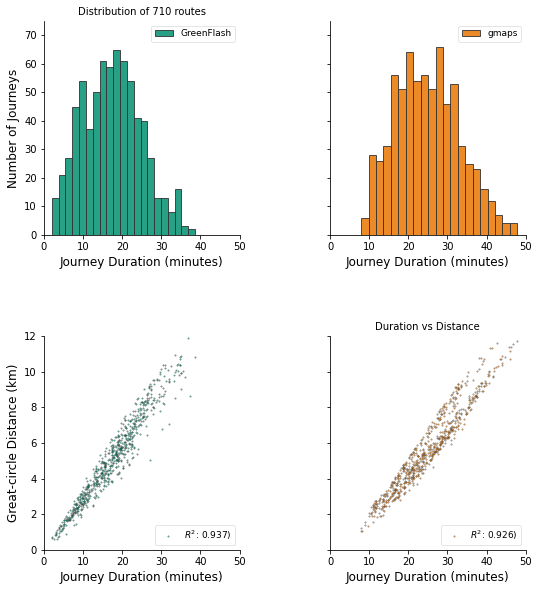

In [ ]:
plot()

As it is obvious from the histograms, the journey times and their distribution vary significantly between the the routes

In [22]:
centroids = {}
for provider in ['GreenFlash', 'gmaps']:
    km = KMeans(init='k-means++', n_clusters=7, n_init=10)
    km.fit(routes[['centroid_distance', 'travel_time_%s' % provider]])
    routes['kmeans_bin_%s' % provider] = km.labels_
    centroids[provider] = km.cluster_centers_

We can also calculate the percentage of route segments each route has in common

In [23]:
routes['GreenFlash_gmaps_similarity'] = routes.apply(
    lambda f: similarity(f['GreenFlash_decoded'], f['gmaps_decoded']), axis=1)

**Outlier detection on the Valhalla data using RANSAC**

In [24]:
time_reshaped = np.reshape(
    routes['travel_time_GreenFlash'].values, (len(routes['travel_time_GreenFlash']), 1))
route_reshaped = np.reshape(
    routes['GreenFlash_route_length_proj'], (len(routes['GreenFlash_route_length_proj']),))

In [28]:
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(), max_trials=1000)
res = model_ransac.fit(time_reshaped, route_reshaped)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

np.sum(outlier_mask)

4

<Figure size 1152x864 with 0 Axes>

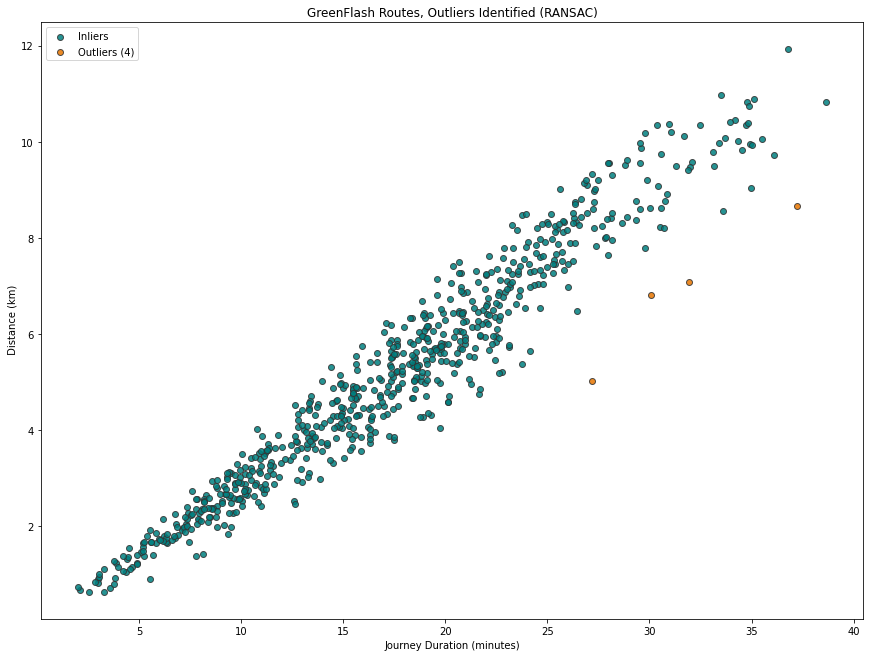

In [33]:
  plt.clf()
  fig = plt.figure(figsize=(16, 12))
  ax = fig.add_subplot(111)

  plt.scatter(
    time_reshaped[inlier_mask], route_reshaped[inlier_mask],
    color="#008080",
    label='Inliers',
    marker='o',
    edgecolor='#333333',
    alpha=.85)

  plt.scatter(
    time_reshaped[outlier_mask], route_reshaped[outlier_mask],
    color="#E87600",
    label='Outliers (%s)' % np.sum(outlier_mask),
    marker='o',
    edgecolor='#333333',
    alpha=.85)

  ax.set_xlabel('Journey Duration (minutes)')
  ax.set_ylabel(' Distance (km)')
  plt.title("GreenFlash Routes, Outliers Identified (RANSAC)")

  plt.legend()
  plt.tight_layout()
  fig.set_size_inches(12, 9)
  plt.savefig(
    'RANSAC.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=72)
  plt.show()

Using the resulting 'mask' arrays, we can see the outlier destinations, and how long Google thinks it should take

In [41]:
comp= routes.loc[outlier_mask][['GreenFlash_route_length_proj', 'gmaps_route_length_proj']]
comp

,GreenFlash_route_length_proj,gmaps_route_length_proj
name,,
"Pembridge Villas, Notting Hill",6.802932,7.336343
"South Kensington Station, South Kensington",7.071861,5.199306
"Harrowby Street, Marylebone",5.020362,5.376170
"Gwendwr Road, West Kensington",8.663382,8.442908


The users with True crosses the criteria of receiving reward points

In [40]:
reward = (routes.loc[outlier_mask]['GreenFlash_route_length_proj'] < routes.loc[outlier_mask]['gmaps_route_length_proj'])
reward

name
Pembridge Villas, Notting Hill                 True
South Kensington Station, South Kensington    False
Harrowby Street, Marylebone                    True
Gwendwr Road, West Kensington                 False
dtype: bool

In [42]:
df1 = routes.loc[outlier_mask]['GreenFlash_route_length_proj']
df2 = routes.loc[outlier_mask]['gmaps_route_length_proj']

The following shows the shortest distance on the particular route

In [45]:
min = comp[['GreenFlash_route_length_proj','gmaps_route_length_proj']].min(axis=1)
min

name
Pembridge Villas, Notting Hill                6.802932
South Kensington Station, South Kensington    5.199306
Harrowby Street, Marylebone                   5.020362
Gwendwr Road, West Kensington                 8.442908
dtype: float64

Here are few maps for the visualization purpose

In [59]:
def gmap_map():
  plt.clf()
  fig = plt.figure(figsize=(16, 12), dpi=300)
  ax = fig.add_subplot(111,  frame_on=False)

  m.fillcontinents('#404040')
  m.drawparallels(
      np.arange(ll[0], ur[0], 2.),
      color = 'black', linewidth = 0.5,
      labels=[True, False, False, False], ax=ax)
  m.drawmeridians(
      np.arange(ll[1], ur[1], 2.),
      color = 'black', linewidth = 0.5,
      labels=[False, False, False, True], ax=ax)

  pc_gmaps = PatchCollection(
      [PolygonPatch(
          line.buffer(20)) for line in MultiLineString(
              list(routes.loc[outlier_mask]['gmaps_decoded_proj']))],
      match_original=False, alpha=.25, color="#E87600", lw=.001, zorder=4)
  
  pc_gmaps.set_label("gmaps")
  ax.add_collection(pc_gmaps)

  m.scatter(
      routes.loc[outlier_mask]['projected_lon'],
      routes.loc[outlier_mask]['projected_lat'],
      s=50,
      color='#ffffff',
      edgecolor='#000000',
      ax=ax,
      zorder=4)

  plt.title("Shorter-than-expected Routes, GreenFlash(%s Routes)" % len(routes.loc[outlier_mask]))

  plt.tight_layout()
  fig.set_size_inches(5, 6)
  plt.savefig(
      'outliers_mapped.png',
      format="png",
      bbox_inches='tight',
      alpha=True,
      transparent=True,
      dpi=72)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


<Figure size 1152x864 with 0 Axes>

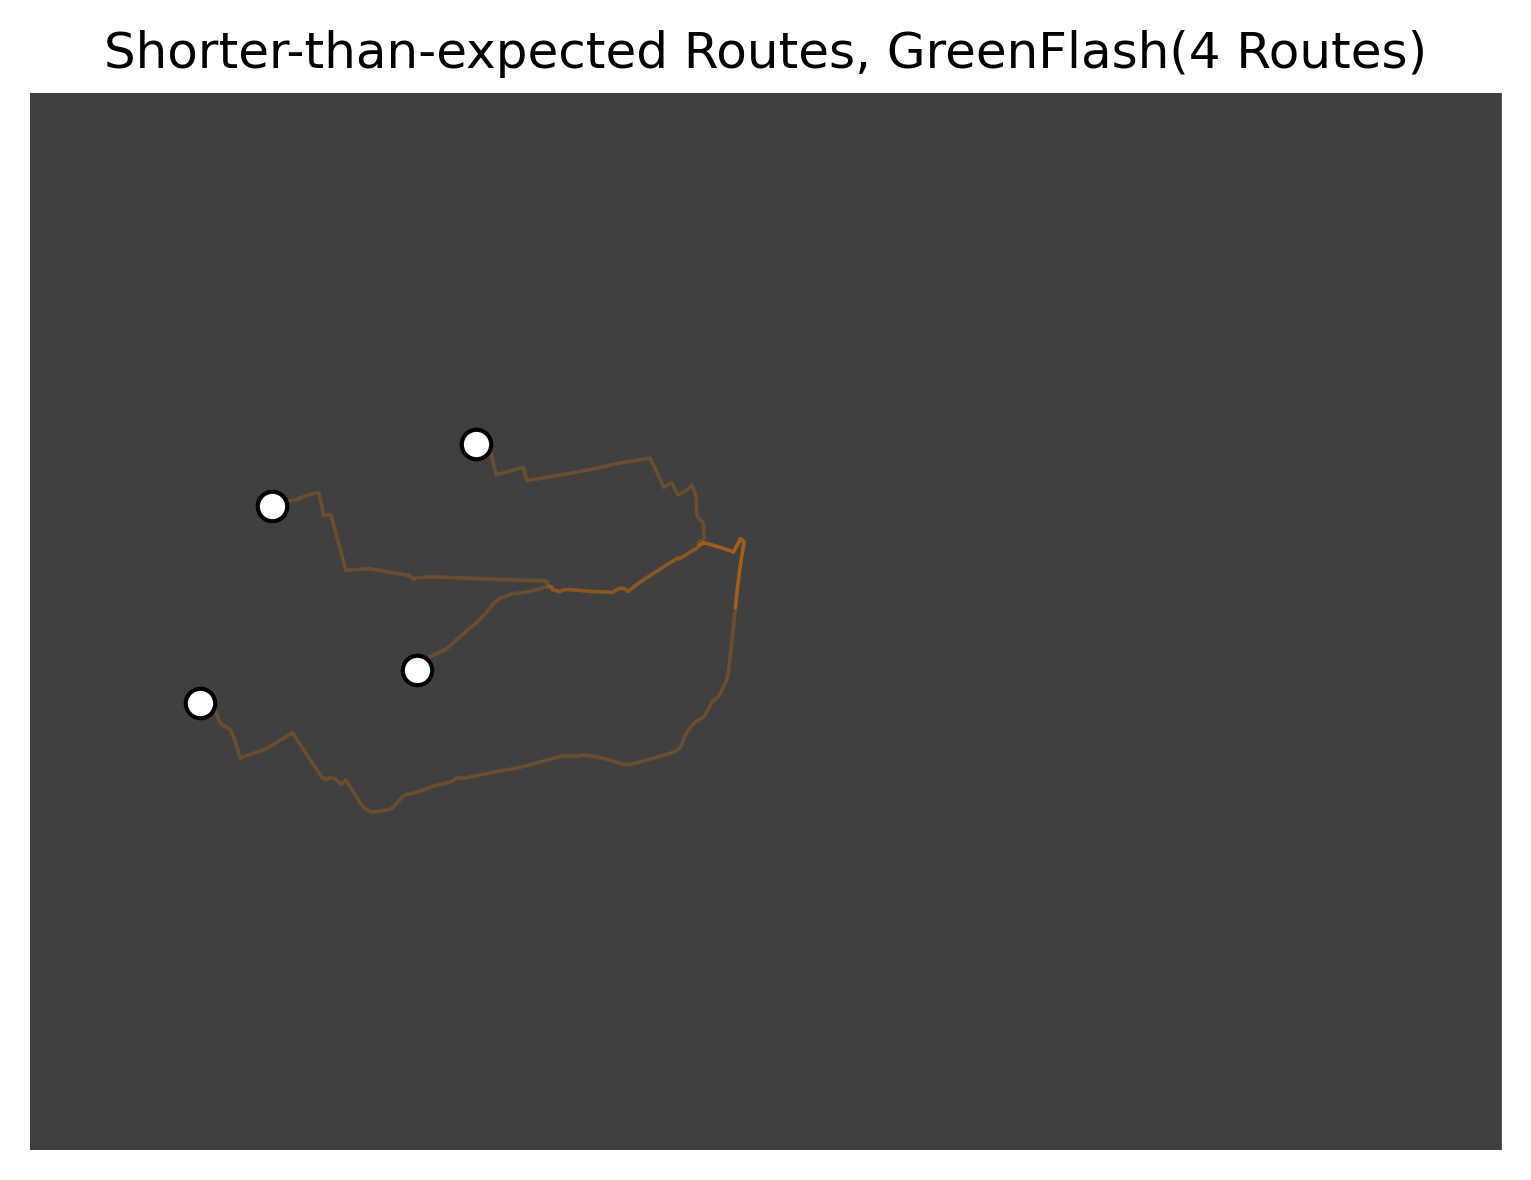

In [60]:
gmap_map()

In [57]:
def GreenFlash_map():
  plt.clf()
  fig = plt.figure(figsize=(16, 12), dpi=300)
  ax = fig.add_subplot(111,  frame_on=False)

  m.fillcontinents('#404040')
  m.drawparallels(
      np.arange(ll[0], ur[0], 2.),
      color = 'black', linewidth = 0.5,
      labels=[True, False, False, False], ax=ax)
  m.drawmeridians(
      np.arange(ll[1], ur[1], 2.),
      color = 'black', linewidth = 0.5,
      labels=[False, False, False, True], ax=ax)

  pc_GreenFlash = PatchCollection(
      [PolygonPatch(
          line.buffer(20)) for line in MultiLineString(
              list(routes.loc[outlier_mask]['GreenFlash_decoded_proj']))],
      match_original=False, alpha=.25, color="#029071", lw=.001, zorder=4)
 
  pc_GreenFlash.set_label("GreenFlash")
  ax.add_collection(pc_GreenFlash)

  m.scatter(
      routes.loc[outlier_mask]['projected_lon'],
      routes.loc[outlier_mask]['projected_lat'],
      s=50,
      color='#ffffff',
      edgecolor='#000000',
      ax=ax,
      zorder=4)

  plt.title("Shorter-than-expected Routes, GreenFlash(%s Routes)" % len(routes.loc[outlier_mask]))

  plt.tight_layout()
  fig.set_size_inches(5, 6)
  plt.savefig(
      'outliers_mapped.png',
      format="png",
      bbox_inches='tight',
      alpha=True,
      transparent=True,
      dpi=72)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


<Figure size 1152x864 with 0 Axes>

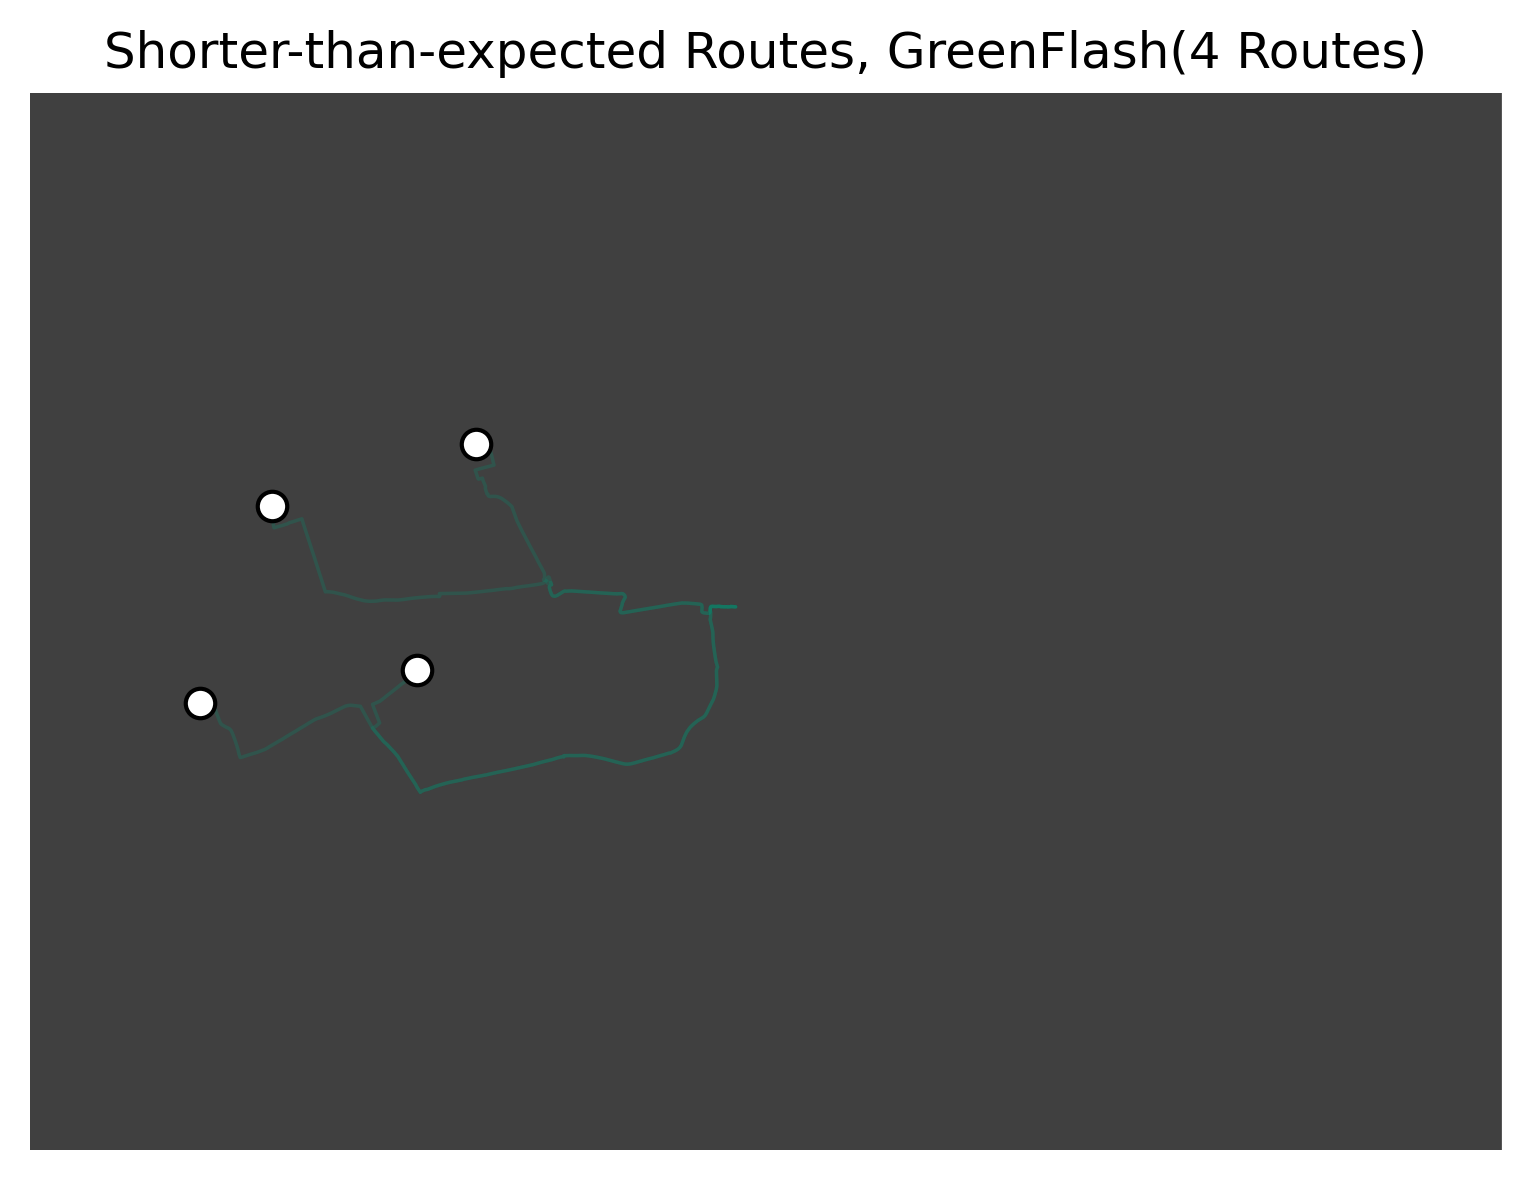

In [58]:
GreenFlash_map()

In [55]:
 def gmap_vs_greenflash():
  plt.clf()
  fig = plt.figure(figsize=(16, 12), dpi=300)
  ax = fig.add_subplot(111,  frame_on=False)

  m.fillcontinents('#404040')
  m.drawparallels(
      np.arange(ll[0], ur[0], 2.),
      color = 'black', linewidth = 0.5,
      labels=[True, False, False, False], ax=ax)
  m.drawmeridians(
      np.arange(ll[1], ur[1], 2.),
      color = 'black', linewidth = 0.5,
      labels=[False, False, False, True], ax=ax)

  pc_GreenFlash = PatchCollection(
      [PolygonPatch(
          line.buffer(20)) for line in MultiLineString(
              list(routes.loc[outlier_mask]['GreenFlash_decoded_proj']))],
      match_original=False, alpha=.25, color="#029071", lw=.001, zorder=4)
  pc_gmaps = PatchCollection(
      [PolygonPatch(
          line.buffer(20)) for line in MultiLineString(
              list(routes.loc[outlier_mask]['gmaps_decoded_proj']))],
      match_original=False, alpha=.25, color="#E87600", lw=.001, zorder=4)
  pc_GreenFlash.set_label("GreenFlash")
  pc_gmaps.set_label("gmaps")
  ax.add_collection(pc_GreenFlash)
  ax.add_collection(pc_gmaps)

  m.scatter(
      routes.loc[outlier_mask]['projected_lon'],
      routes.loc[outlier_mask]['projected_lat'],
      s=50,
      color='#ffffff',
      edgecolor='#000000',
      ax=ax,
      zorder=4)

  plt.title("Shorter-than-expected Routes, GreenFlash(%s Routes)" % len(routes.loc[outlier_mask]))

  plt.tight_layout()
  fig.set_size_inches(5, 6)
  plt.savefig(
      'outliers_mapped.png',
      format="png",
      bbox_inches='tight',
      alpha=True,
      transparent=True,
      dpi=72)

  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


<Figure size 1152x864 with 0 Axes>

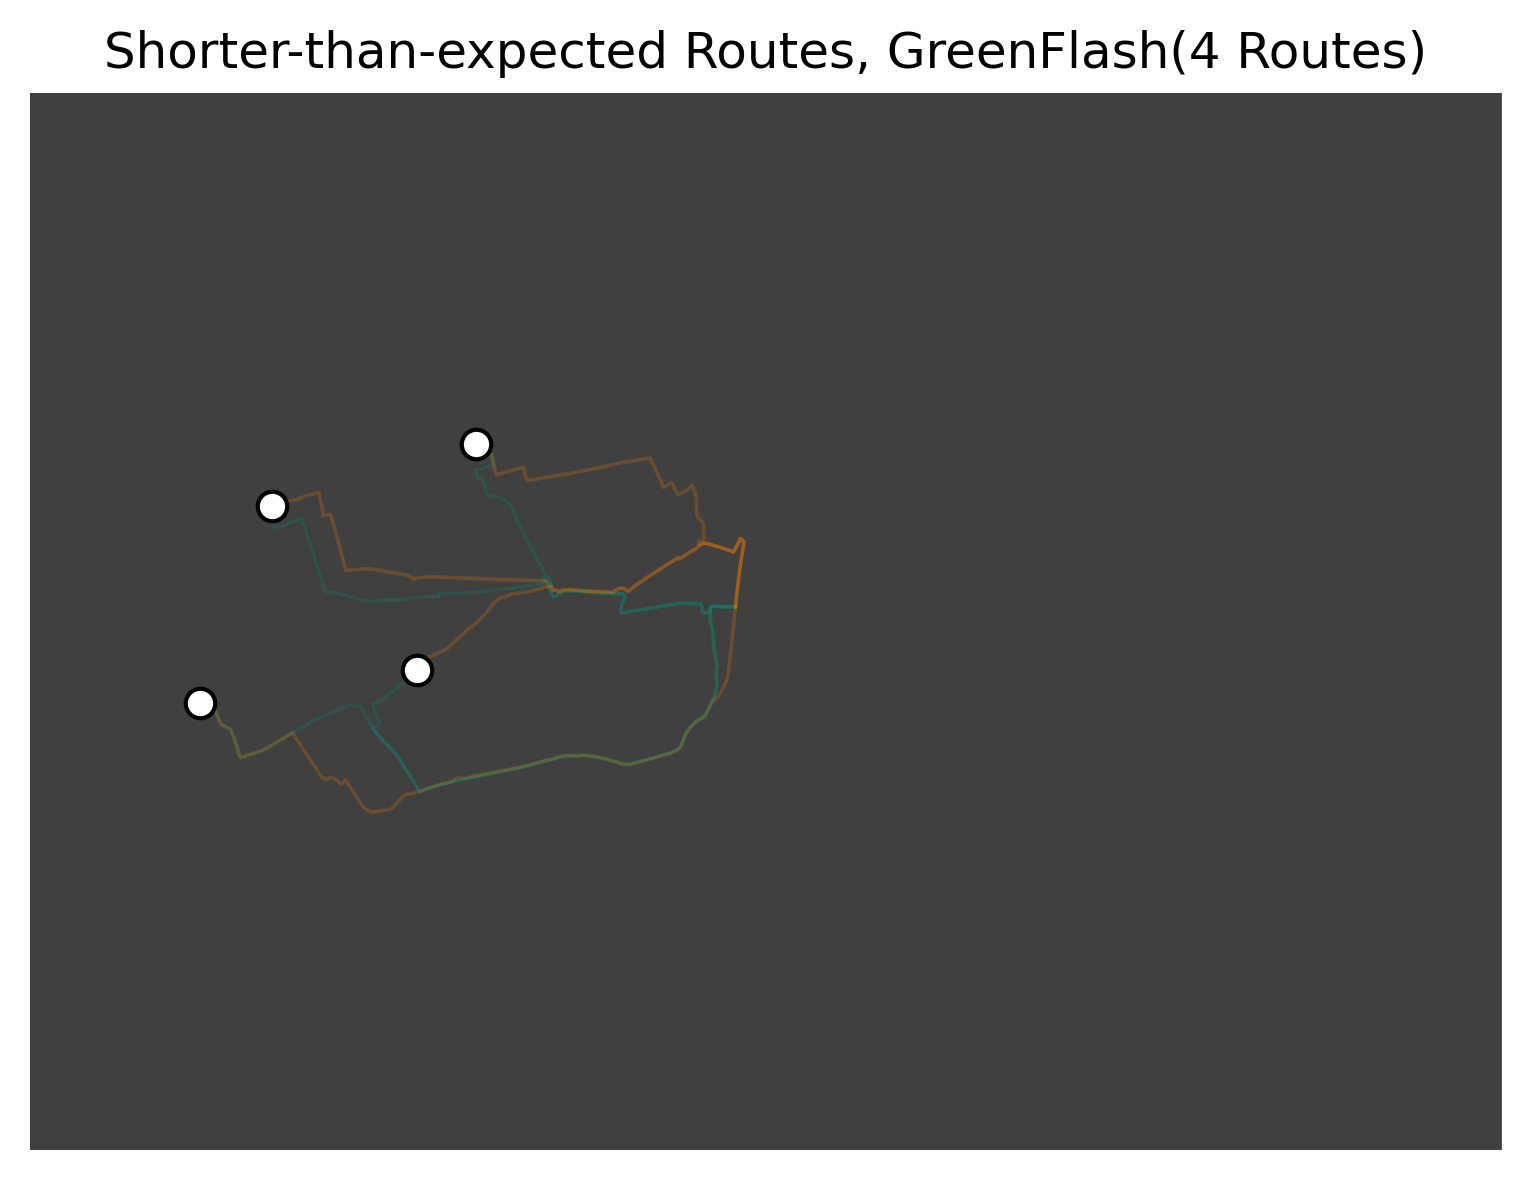

In [56]:
gmap_vs_greenflash()